In [1]:
# Import brmspy - works for both installed package and cloned repo
import sys
import os

try:
    # Try importing as installed package
    import brmspy
    from brmspy import brms
    print(f"✓ Using installed brmspy {brmspy.__version__}")
except ImportError:
    # Fall back to importing from cloned repo
    # Add parent directory to path (assumes running from examples/)
    repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if repo_root not in sys.path:
        sys.path.insert(0, repo_root)
    
    try:
        import brmspy
        from brmspy import brms
        print(f"✓ Using brmspy from repository: {repo_root}")
        print(f"  Version: {brmspy.__version__}")
    except ImportError as e:
        print("✗ Could not import brmspy!")
        print("  Please either:")
        print("  1. Install: pip install brmspy")
        print("  2. Or run from repository root with: jupyter notebook examples/getting_started.ipynb")
        raise

# Import other required packages
import pandas as pd
import numpy as np

import arviz as az
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("Setup complete!")
print("="*60)

Error importing in API mode: ImportError("dlopen(/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <05EE76C0-33BF-3D4C-BC56-84005241BC88> /Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


✓ Using installed brmspy 0.1.3

Setup complete!


In [2]:
df = brms.get_brms_data("epilepsy")

In [3]:
model = brms.fit(
    formula="count ~ zAge + zBase * Trt + (1|patient)",
    family="negbinomial", 
    data=df,
    
    # 1. ALGORITHM
    algorithm="meanfield",
    
    # 2. OPTIMIZATION LOOP
    iter=30000,
    eta=0.1,
    adapt_engaged=True,
    
    # 3. GRADIENT ESTIMATION (Reducing Noise)
    grad_samples=5,
    elbo_samples=100,
    
    # 4. CONVERGENCE CRITERIA
    eval_elbo=200,
    tol_rel_obj=0.0001,
    
    seed=42
)

R callback write-console: Compiling Stan program...
  


Fitting model with brms (backend: cmdstanr)...


R callback write-console: Start sampling
  


------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 6.3e-05 seconds 
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   200         -650.397             1.000            1.000 
   400         -650.707             0.500            1.000 
   600         -648.679             0.335       

In [4]:
model.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [5]:
plt.style.use('bmh')

Computed from 1000 posterior samples and 236 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -622.01    17.23
p_loo       44.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)      227   96.2%
   (0.67, 1]   (bad)         9    3.8%
   (1, Inf)   (very bad)    0    0.0%



/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


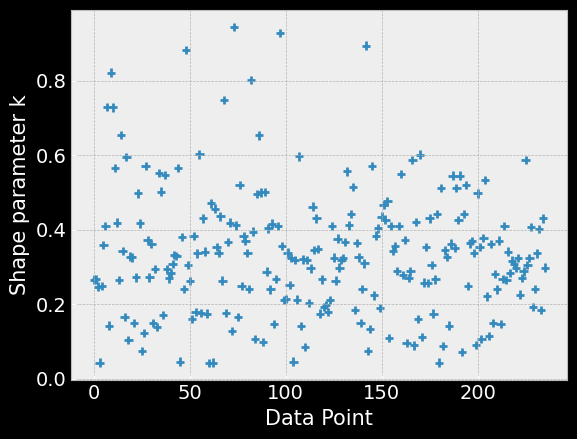

In [6]:
loo_res = az.loo(model.idata, pointwise=True)
print(loo_res)

# Visualize the k-hats
az.plot_khat(loo_res)
plt.show()

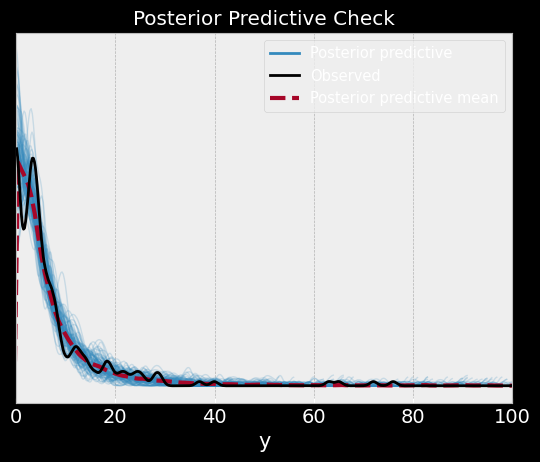

In [7]:

az.plot_ppc(model.idata, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.xlim(0, 100)
plt.show()

In [8]:
pred = brms.posterior_predict(model)

In [15]:
df_summary = brms.summary(model)

print(df_summary.to_string(index=True, justify="right", float_format="%.2f"))

            Estimate  Est.Error  l-95% CI  u-95% CI  Rhat  Bulk_ESS  Tail_ESS
Intercept       1.79       0.06      1.68      1.90  1.00   1119.45    983.44
zAge            0.10       0.04      0.02      0.18  1.00   1163.52    979.43
zBase           0.70       0.03      0.63      0.76  1.00    926.45    907.70
Trt1           -0.26       0.08     -0.41     -0.11  1.00   1065.05    980.16
zBase:Trt1      0.05       0.04     -0.02      0.14  1.00    948.40    940.45
